## Cooking

https://www.kaggle.com/c/whats-cooking

In [1]:
import warnings
warnings.filterwarnings('ignore') #ignore warning messages 
# Python libraries
# Handle data
import json
import collections
import re
import random

# Handle table-like data 
import numpy as np
import pandas as pd

# Model Algorithms
from gensim.models import word2vec
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import grid_search
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 1. Data preparing

In [2]:
train=pd.read_json('train.json')
test=pd.read_json('test.json')
submission=pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [4]:
print('train size:',train.shape)
print('test size:',test.shape)

train size: (39774, 3)
test size: (9944, 2)


In [5]:
data=train.append(test)

## 2. EDA

In [6]:
train['ingredients_clean_string'] = [' , '.join(z).strip() for z in train['ingredients']]
train.head()

,cuisine,id,ingredients,ingredients_clean_string
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce , black olives , grape tomatoe..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour , ground pepper , salt , tomatoes ..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs , pepper , salt , mayonaise , cooking oil..."
3,indian,22213,"[water, vegetable oil, wheat, salt]","water , vegetable oil , wheat , salt"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","black pepper , shallots , cornflour , cayenne ..."


In [7]:
# Load the dataset
# json format labels: cuisine, id number and ingredients (list)
trainrecipts = json.load(open('train.json','r'))

In [8]:
# Quick&dirty code to extract info2list
raw_ingredients = list()

for recipt in trainrecipts:
    for ingredient in recipt[u'ingredients']:
        raw_ingredients.append(ingredient.strip())
        

raw_cuisines = list()
for recipt in trainrecipts:
    raw_cuisines.append(recipt[u'cuisine'].strip())

In [9]:
# use Counter to get frequencies 
counts_ingr = collections.Counter(raw_ingredients)
counts_cuis = collections.Counter(raw_cuisines)

In [10]:
# this will help us to have an idea how our corpora of 
# ingredients looks like
print('Size Ingredients dataset (with repetition):  \t{}'.format((len(raw_ingredients))))
print('Unique Ingredients dataset: \t\t\t{}'.format((len(counts_ingr.values()))))

# This will provide a distribution of cusines, indirect 
# info of the ingredients
print('Total # of recipts \t\t\t\t{}'.format(len(raw_cuisines)))
print('Total # of Cuisines \t\t\t\t{}'.format((len(counts_cuis.values()))))

Size Ingredients dataset (with repetition):  	428275
Unique Ingredients dataset: 			6714
Total # of recipts 				39774
Total # of Cuisines 				20


In [11]:
# top 10
counts_cuis.most_common(10)

[('italian', 7838),
 ('mexican', 6438),
 ('southern_us', 4320),
 ('indian', 3003),
 ('chinese', 2673),
 ('french', 2646),
 ('cajun_creole', 1546),
 ('thai', 1539),
 ('japanese', 1423),
 ('greek', 1175)]

In [12]:
#也可以用pandas
train['cuisine'].value_counts().values

array([7838, 6438, 4320, 3003, 2673, 2646, 1546, 1539, 1423, 1175,  989,
        830,  825,  821,  804,  755,  667,  526,  489,  467])

### Cuisine

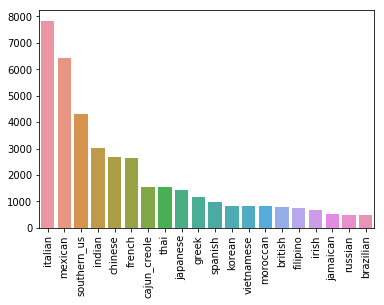

In [13]:
x_label= train['cuisine'].value_counts().index
y_label= train['cuisine'].value_counts().values
fbar = sns.barplot(x = x_label, y = y_label)
#xlabels
for item in fbar.get_xticklabels():
    item.set_rotation(90)

itlian和mexican很多，但其他都比較少，training data 偏向這個地區的資料

In [14]:
# Distribution 
print(np.mean(list(counts_cuis.values())))
print(np.std(list(counts_cuis.values())))

1988.7
1989.865349715905


In [15]:
# init a dict with a empty list
num_ingredients = dict(zip(counts_cuis.keys(), [list() for x in counts_cuis.keys()]))
for recipt in trainrecipts:
    # append the number in the list
    num_ingredients[recipt['cuisine']].append(len(recipt['ingredients']))

len(num_ingredients)

20

### Ingredients

In [16]:
for cu, frq in num_ingredients.items():

    print('{}    \t\t{:.2f}'.format(cu, np.mean(frq)))

greek    		10.18
southern_us    		9.63
filipino    		10.00
indian    		12.71
jamaican    		12.21
spanish    		10.42
italian    		9.91
mexican    		10.88
chinese    		11.98
british    		9.71
thai    		12.55
vietnamese    		12.68
cajun_creole    		12.62
brazilian    		9.52
french    		9.82
japanese    		9.74
irish    		9.30
korean    		11.28
moroccan    		12.91
russian    		10.22


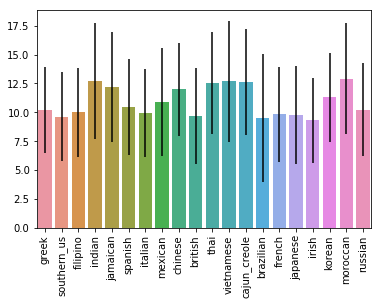

In [17]:
x_cu = [cu for cu, frq in num_ingredients.items()]
y_frq = [np.mean(frq) for cu, frq in num_ingredients.items()]
err = [np.std(frq) for cu, frq in num_ingredients.items()]
fbar = sns.barplot(x = x_cu, y = y_frq, yerr=err)
# xlabels
for item in fbar.get_xticklabels():
    item.set_rotation(90)

In [18]:
# Dispersion of the frequencies Ingredients
print(np.mean(list(counts_ingr.values())))
print(np.std(list(counts_ingr.values())))

63.7883526958594
388.3270259662557


In [19]:
# This is to big to plot, let's check the percentiles
print(np.median(list(counts_ingr.values())))
print(np.percentile(list(counts_ingr.values()), [25., 50., 75., 100.]))

4.0
[1.0000e+00 4.0000e+00 2.0000e+01 1.8049e+04]


In [20]:
# top 15
counts_ingr.most_common(15)

[('salt', 18049),
 ('onions', 7972),
 ('olive oil', 7972),
 ('water', 7457),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic cloves', 6237),
 ('butter', 4848),
 ('ground black pepper', 4785),
 ('all-purpose flour', 4632),
 ('pepper', 4438),
 ('vegetable oil', 4385),
 ('eggs', 3388),
 ('soy sauce', 3296),
 ('kosher salt', 3113)]

In [21]:
# Tail 50
counts_ingr.most_common()[-50:]

[('tonic water', 1),
 ('Chartreuse Liqueur', 1),
 ('aloe juice', 1),
 ('salt free chili powder', 1),
 ('tofu sour cream', 1),
 ('spicy salami', 1),
 ('Honeysuckle White® Hot Italian Turkey Sausage Links', 1),
 ('chocolate extract', 1),
 ('chocolate graham crackers', 1),
 ('cumberland sausage', 1),
 ('cocktail pumpernickel bread', 1),
 ('chunky tomatoes', 1),
 ("Colman's Mustard Powder", 1),
 ('manouri', 1),
 ('cherry vanilla ice cream', 1),
 ('bone-in ribeye steak', 1),
 ('frozen lemonade concentrate, thawed and undiluted', 1),
 ('flowering chinese chives', 1),
 ('praline topping', 1),
 ('riblets', 1),
 ('puff paste', 1),
 ('Barilla Plus Pasta', 1),
 ('turkey giblet stock', 1),
 ('light chicken stock', 1),
 ('conchiglie', 1),
 ('2% milk shredded mozzarella cheese', 1),
 ('Makers Mark Whisky', 1),
 ('knorr pasta side   cheesi cheddar', 1),
 ('whole grain baguette', 1),
 ('reduced sodium ham', 1),
 ('whole wheat peasant bread', 1),
 ('ranch-style seasoning', 1),
 ('ketjap', 1),
 ('chocol

## TF-IDF

In [22]:
train['ingredients_list'] = [' , '.join(z).strip() for z in train['ingredients']]
ingredients = train['ingredients_list']
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(ingredients).todense()

In [25]:
bag_of_words = vectorizer.get_feature_names()
print("Bag of words:")
print(bag_of_words)

Bag of words:
['00', '10', '100', '14', '15', '25', '33', '40', '43', '95', '96', 'abalone', 'abbamele', 'absinthe', 'abura', 'acai', 'accent', 'accompaniment', 'achiote', 'acid', 'acini', 'ackee', 'acorn', 'acting', 'activ', 'active', 'added', 'adobo', 'adzuki', 'agar', 'agave', 'age', 'aged', 'ahi', 'aioli', 'ajinomoto', 'ajwain', 'aka', 'alaskan', 'albacore', 'alcohol', 'ale', 'aleppo', 'alexia', 'alfalfa', 'alfredo', 'allspice', 'almond', 'almondmilk', 'almonds', 'aloe', 'alphabet', 'alum', 'amaranth', 'amarena', 'amaretti', 'amaretto', 'amba', 'amber', 'amberjack', 'amchur', 'america', 'american', 'aminos', 'ammonium', 'amontillado', 'ampalaya', 'anaheim', 'anasazi', 'ancho', 'anchovies', 'anchovy', 'andouille', 'anejo', 'angel', 'anglaise', 'angled', 'angostura', 'angus', 'anise', 'anisette', 'anjou', 'annatto', 'aonori', 'apple', 'apples', 'applesauce', 'applewood', 'apricot', 'apricots', 'aquavit', 'arak', 'arame', 'arbol', 'arborio', 'arctic', 'arepa', 'argo', 'arhar', 'armagn

In [26]:
tfidf_matrix 

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
tfidf_matrix.shape

(39774, 2970)

In [28]:
cuisines=train['cuisine']

In [29]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=500,max_features=10)
rf_clf.fit(tfidf_matrix, cuisines)

CPU times: user 3min 42s, sys: 7.24 s, total: 3min 49s
Wall time: 4min 11s


In [30]:
pred_train=rf_clf.predict(tfidf_matrix)

In [31]:
pred_train.shape

(39774,)

In [32]:
from sklearn.metrics import accuracy_score
accuracy_score(pred_train, cuisines)

0.9996228692110424

## Predict

In [33]:
test['ingredients_list'] = [' , '.join(z).strip() for z in test['ingredients']]
test_ingredients = test['ingredients_list']
test_tfidf_matrix = vectorizer.transform(test_ingredients)
test_cuisines = rf_clf.predict(test_tfidf_matrix)

In [34]:
test_tfidf_matrix.shape

(9944, 2970)

In [35]:
test['cuisine']=test_cuisines
test[['id' , 'cuisine' ]].to_csv("submission3.csv", index=False)

In [36]:
test

,id,ingredients,ingredients_list,cuisine
0,18009,"[baking powder, eggs, all-purpose flour, raisi...","baking powder , eggs , all-purpose flour , rai...",southern_us
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...","sugar , egg yolks , corn starch , cream of tar...",southern_us
2,41580,"[sausage links, fennel bulb, fronds, olive oil...","sausage links , fennel bulb , fronds , olive o...",italian
3,29752,"[meat cuts, file powder, smoked sausage, okra,...","meat cuts , file powder , smoked sausage , okr...",cajun_creole
4,35687,"[ground black pepper, salt, sausage casings, l...","ground black pepper , salt , sausage casings ,...",italian
5,38527,"[baking powder, all-purpose flour, peach slice...","baking powder , all-purpose flour , peach slic...",southern_us
6,19666,"[grape juice, orange, white zinfandel]","grape juice , orange , white zinfandel",southern_us
7,41217,"[ground ginger, white pepper, green onions, or...","ground ginger , white pepper , green onions , ...",chinese
8,28753,"[diced onions, taco seasoning mix, all-purpose...","diced onions , taco seasoning mix , all-purpos...",mexican
9,22659,"[eggs, cherries, dates, dark muscovado sugar, ...","eggs , cherries , dates , dark muscovado sugar...",british
